# 1.Import Data
## 1.1.Import Prediction

In [199]:
# import libraries
import pickle
import tensorflow as tf
import pandas as pd
import re
from tqdm import tqdm
import numpy as np

In [200]:
path_dict0={
    # compare the baseline data with different data structure
    "LogisticRegression_overall_baseline_preds":"baseline_overall_logisticregression_preds",
    "LogisticRegression_delete2nd_baseline_preds":"baseline_delete2_logisticregression_preds",
    "LogisticRegression_double1st3rd_baseline_preds":"baseline_double_logisticregression_preds",
    "LogisticRegression_time3_baseline_preds":"baseline_time3_logisticregression_preds",
    "LogisticRegression_del2big3_baseline_preds":"baseline_del2big3_logisticregression_preds",
    
    # compare the baseline data with different data structure
    "SVM_overall_baseline_preds":"baseline_overall_svm_preds",
    "SVM_delete2nd_baseline_preds":"baseline_delete2_svm_preds",
    "SVM_double1st3rd_baseline_preds":"baseline_double_svm_preds",
    "SVM_time3_baseline_preds":"baseline_time3_svm_preds",
    "SVM_del2big3_baseline_preds":"baseline_del2big3_svm_preds",
    
    # the comparison of different infrastructure of word embedding {overall, double the values of 1st turn and 2nd turn, double the value
    # of 1st turn and 3 times the values of 3rd turn}
    "LogisticRegression_compare_word2vec":"LogisticRegression_process3turn_word2vec_preds",
    "LogisticRegression_compare_glove":"LogisticRegression_process3turn_glove_preds",
    
    # the comparison of different infrastructure of word embedding {overall, double the values of 1st turn and 2nd turn, double the value
    # of 1st turn and 3 times the values of 3rd turn}
    "SVM_compare_word2vec":"SVM_process3turn_word2vec_preds",
    "SVM_compare_glove":"SVM_process3turn_glove_preds",
    
    "LogisticRegression_preds":"LogisticRegression_preds",
    "CNN_preds":"CNN_preds",
    "Kernel_SVM_preds":"Kernel_SVM_preds",
    "SVM_preds":"SVM_preds",
    "LSTM_preds":"LSTM_preds",
    "GRU_preds":"GRU_preds",
    "BiLSTM_preds":"BiLSTM_preds",
    "BiGRU_preds":"BiGRU_preds",
    "BiLSTM_self-attention_preds":"BiLSTM_self-attention_preds",
    "BiGRU_self-attention_preds":"BiGRU_self-attention_preds"
    
}

path_dict1={
    "LogisticRegression_baseline_scores":"baseline_time3_logisticregression_scores",
    "SVM_baseline_scores":"baseline_time3_svm_scores",
    "LogisticRegression_scores":"LogisticRegression_scores",
    "CNN_scores":"CNN_scores",
    "Kernel_SVM_scores":"Kernel_SVM_scores",
    "SVM_scores":"SVM_scores",
    "LSTM_scores":"LSTM_scores",
    "GRU_scores":"GRU_scores",
    "BiLSTM_scores":"BiLSTM_scores",
    "BiGRU_scores":"BiGRU_scores",
    "BiLSTM_self-attention_scores":"BiLSTM_self-attention_scores",
    "BiGRU_self-attention_scores":"BiGRU_self-attention_scores",
}

In [201]:
def open_pkl(parent_path,file_name):
    all_data=dict()
    for each_key in file_name.keys():
        name = file_name[each_key]
        pickle_file = open(parent_path+name+".pkl",mode="rb")
        data = pickle.load(pickle_file)
        pickle_file.close()
        all_data[each_key]=data
    return all_data

In [202]:
parent_path = "Prediction\\"
all_preds=open_pkl(parent_path,path_dict0)
all_scores=open_pkl(parent_path,path_dict1)

In [203]:
all_preds["LogisticRegression_del2big3_baseline_preds"]

{'test_baseline': array([0, 0, 3, ..., 0, 0, 0])}

In [204]:
all_scores["BiLSTM_scores"]

{'test2': array([[3.7407994e-01, 3.6126592e-05, 8.4304093e-06, 8.9555624e-06],
        [7.8704846e-01, 8.1371663e-06, 4.0391451e-06, 6.0571638e-06],
        [1.0467172e-03, 1.2628819e-06, 4.3868786e-05, 1.0869455e-01],
        ...,
        [7.4406874e-01, 1.0585654e-05, 7.9493211e-06, 5.5507803e-06],
        [7.5490505e-01, 6.7935553e-06, 4.9636396e-06, 5.1591983e-06],
        [5.8194810e-01, 1.2189081e-05, 8.2658598e-06, 2.1969052e-05]],
       dtype=float32),
 'test5': array([[7.55582511e-01, 2.49253526e-06, 7.24293841e-06, 1.44591086e-05],
        [8.82074773e-01, 2.62877575e-06, 1.63894651e-06, 1.36459685e-05],
        [5.08606434e-03, 4.56497844e-07, 6.87125976e-07, 8.44910741e-03],
        ...,
        [3.14730525e-01, 5.16629325e-06, 1.42867711e-05, 6.40510007e-06],
        [4.68327701e-01, 6.83870667e-06, 1.96591536e-05, 2.42995679e-06],
        [8.96423876e-01, 3.26905661e-06, 9.79985884e-07, 1.69431132e-05]],
       dtype=float32)}

## 1.2.Import y_test

In [205]:
y_name={
    "y_test":"test_y",
    "y_train":"train_y"
}

In [206]:
parent_path="DataSet\\"
y_data = open_pkl(parent_path,y_name)
y_test = y_data["y_test"]

In [207]:
# in order to plot ROC curve and calculate AUC, I need to turn y label into 1 hot representation.
# transfer y label from {class:[0,1,2,3]} into {class: [1,0,0,0], [0,1,0,0],[0,0,1,0],[0,0,0,1]}
emotion = {"others":0,"happy":1,"sad":2,"angry":3}
y_test1hot = tf.keras.utils.to_categorical(y_test,num_classes=4)

## 1.3.Calculation on label

In [208]:
# function for calculate the number of each class in label
def calculate_class_no(y):
    emotion = {
        0:"others",
        1:"happy",
        2:"sad",
        3:"angry"
        }
    
    cal_y=dict()
    cal_y["others"]=0
    cal_y["happy"]=0
    cal_y["sad"]=0
    cal_y["angry"]=0
    length = len(y)
    for i in range(length):
        if y[i] == 0:
            cal_y["others"] +=1
        elif y[i] == 1:
            cal_y["happy"] +=1
        elif y[i] ==2:
            cal_y["sad"] +=1
        elif y[i] ==3:
            cal_y["angry"]+=1
    
    return cal_y

In [209]:
# function for crawl the dict and caculate the number of each class on label
def calculate_class_no_all(y_data):
    y_cal = dict()
    for key in y_data.keys():
        y_cal_one = calculate_class_no(y_data[key])
        y_cal[key]=y_cal_one
    
    return y_cal

In [210]:
# function for forming dataframe
def form_df_y(y_cal):
    new_dict = dict()
    columns = ["data version","others","happy","sad","angry"]
    for each in columns:
        new_dict[each]=list()
    
    for each_key in y_cal.keys():
        new_dict["data version"].append(each_key)
        for each_data in y_cal[each_key].keys():
            new_dict[each_data].append(y_cal[each_key][each_data])
    df = pd.DataFrame.from_dict(new_dict)
    
    return df

In [211]:
y_cal = calculate_class_no_all(y_data)

In [212]:
y_cal

{'y_test': {'others': 4677, 'happy': 284, 'sad': 250, 'angry': 298},
 'y_train': {'others': 14948, 'happy': 4243, 'sad': 5463, 'angry': 5506}}

In [213]:
df_y = form_df_y(y_cal)

# save dataframe as excel for further comparison picture extraction
save_path="Prediction\\df_y"
df_y.to_excel(save_path+".xlsx",sheet_name="comparison_evaluation")

In [214]:
df_y

,data version,others,happy,sad,angry
0,y_test,4677,284,250,298
1,y_train,14948,4243,5463,5506


# 2.Evaluation on accuracy, precision, recall, F1 score

In [215]:
# function for getting accuracy, precision, recall, F1 score on each label
def calculate_eachlabel(y_test,y_pred,choose):
    emotion={
        "others":0,
        "happy":1,
        "sad":2,
        "angry":3
        }
    label_choose = emotion[choose]
    
    TP =0
    TN =0
    FP =0
    FN =0
    
    for i in range(len(y_test)):
        if y_test[i] == label_choose and y_pred[i] == label_choose:
            TP +=1
            
        elif y_test[i] == label_choose and y_pred[i] != label_choose:
            FN +=1
        
        elif y_test[i] != label_choose and y_pred[i] == label_choose:
            FP +=1
        elif y_test[i] != label_choose and y_pred[i] != label_choose:
            TN +=1
    accuracy = (TP + TN)/(TP + TN + FP + FN)
    precision = TP/(TP + FP)
    recall = TP/(TP + FN)
    if precision == 0 and recall ==0:
        f1_score =0
    else:
        f1_score = 2*(precision*recall)/(precision + recall)
    
    return accuracy,precision,recall,f1_score

In [216]:
# function for calculating the micro metrics from all labels except "others"
def cal_micro_metrics_noothers(y_test, y_pred):
    emotion = {
        "others": 0,
        "happy": 1,
        "sad": 2,
        "angry": 3
    }

    TP = 0
    TN = 0
    FP = 0
    FN = 0
    emotion_list=[1,2,3]
    # here let's not consider others
    for each in emotion_list:
        for i in range(len(y_test)):
            if y_test[i] == each and y_pred[i] == each:
                TP += 1

            elif y_test[i] == each and y_pred[i] != each:
                FN += 1

            elif y_test[i] != each and y_pred[i] == each:
                FP += 1

    for i in range(len(y_test)):
        if y_test[i] == 0 and y_pred[i] == 0:
            TN +=1

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    if precision == 0 and recall == 0:
        f1_score = 0
    else:
        f1_score = 2 * (precision * recall) / (precision + recall)

    return accuracy, precision, recall, f1_score

In [217]:
#from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
# print evaluation result
def get_evaluation(y_test,y_pred):
    emotion = ["others","happy","sad","angry"]
    ev = dict()
    #ev["confusion_matrix"]=confusion_matrix(y_test,y_pred)
    ev["accuracy"] = accuracy_score(y_test,y_pred)
    ev["precision_macro"]=precision_score(y_test,y_pred,average="macro")
    ev["precision_micro"]=precision_score(y_test,y_pred,average="micro")
    ev["precision_weighted"]=precision_score(y_test,y_pred,average="weighted")
    ev["recall_macro"]=recall_score(y_test,y_pred,average="macro")
    ev["recall_micro"]=recall_score(y_test,y_pred,average="micro")
    ev["recall_weighted"]=recall_score(y_test,y_pred,average="weighted")
    ev["F1_score_macro"]=f1_score(y_test,y_pred,average="macro")
    ev["F1_score_micro"]=f1_score(y_test,y_pred,average="micro")
    ev["F1_score_weighted"]=f1_score(y_test,y_pred,average="weighted")
    for each in emotion:
        accu_each = "accuracy_{0}".format(each)
        pre_each = "precision_{0}".format(each)
        re_each ="recall_{0}".format(each)
        f1_each = "F1_score_{0}".format(each)
        ev[accu_each],ev[pre_each],ev[re_each],ev[f1_each]=calculate_eachlabel(y_test,y_pred,each)
    ev["micro_accuracy-others"],\
    ev["micro_precision-others"],\
    ev["micro_recall-others"],\
    ev["micro_F1-others"] = cal_micro_metrics_noothers(y_test, y_pred)

    return ev

In [218]:
def process_preds(y_test,all_preds,method):
    all_results=dict()
    for each_model in all_preds.keys():
        alldata_results=dict()
        for each_data in all_preds[each_model].keys():
            result = eval(method)(y_test,all_preds[each_model][each_data])
            alldata_results[each_data]=result
        all_results[each_model]=alldata_results
    
    return all_results

In [219]:
all_ev = process_preds(y_test,all_preds,"get_evaluation")

In [220]:
# form dataframe from evaluation dict
def form_df(all_evaluation):
    
    columns=["model","data version","accuracy","precision_macro",
             "recall_macro","F1_score_macro","precision_micro","recall_micro",
             "F1_score_micro","precision_weighted","recall_weighted",
             "F1_score_weighted","micro_accuracy-others" , 
             "micro_precision-others" , "micro_recall-others" , "micro_F1-others"]
    
    emotion = ["others","happy","sad","angry"]
    for each in emotion:
        accu_each = "accuracy_{0}".format(each)
        pre_each = "precision_{0}".format(each)
        re_each ="recall_{0}".format(each)
        f1_each = "F1_score_{0}".format(each)
        columns.append(accu_each)
        columns.append(pre_each)
        columns.append(re_each)
        columns.append(f1_each)
    
    new_dict = dict()
    
    for each_column in columns:
        new_dict[each_column]=list()
    
    for each_model in all_evaluation.keys():
        for each_data in all_evaluation[each_model].keys():
            modelname = re.sub(r'\_baseline','',each_model)
            new_dict["model"].append(re.sub(r'\_preds','',modelname))
            new_dict["data version"].append(each_data)
            
            for each_column in all_evaluation[each_model][each_data].keys():
                new_dict[each_column].append(all_evaluation[each_model][each_data][each_column])
            
    
    df=pd.DataFrame.from_dict(new_dict)
    
    return df

In [221]:
df=form_df(all_ev)
# save dataframe as excel for further comparison picture extraction
save_path="Prediction\\df_evaluation"
df.to_excel(save_path+".xlsx",sheet_name="comparison_evaluation")

In [222]:
df

,model,data version,accuracy,precision_macro,recall_macro,F1_score_macro,precision_micro,recall_micro,F1_score_micro,precision_weighted,...,recall_happy,F1_score_happy,accuracy_sad,precision_sad,recall_sad,F1_score_sad,accuracy_angry,precision_angry,recall_angry,F1_score_angry
0,LogisticRegression_overall,test_baseline,0.730804,0.431355,0.581293,0.473911,0.730804,0.730804,0.730804,0.826814,...,0.415493,0.274419,0.911055,0.260956,0.524,0.348404,0.912507,0.333333,0.617450,0.432941
1,LogisticRegression_delete2nd,test_baseline,0.786350,0.486770,0.627526,0.535024,0.786350,0.786350,0.786350,0.844096,...,0.443662,0.358974,0.924306,0.308046,0.536,0.391241,0.927755,0.403846,0.704698,0.513447
2,LogisticRegression_double1st3rd,test_baseline,0.786350,0.486770,0.627526,0.535024,0.786350,0.786350,0.786350,0.844096,...,0.443662,0.358974,0.924306,0.308046,0.536,0.391241,0.927755,0.403846,0.704698,0.513447
3,LogisticRegression_time3,test_baseline,0.786350,0.486770,0.627526,0.535024,0.786350,0.786350,0.786350,0.844096,...,0.443662,0.358974,0.924306,0.308046,0.536,0.391241,0.927755,0.403846,0.704698,0.513447
4,LogisticRegression_del2big3,test_baseline,0.786350,0.486770,0.627526,0.535024,0.786350,0.786350,0.786350,0.844096,...,0.443662,0.358974,0.924306,0.308046,0.536,0.391241,0.927755,0.403846,0.704698,0.513447
5,SVM_overall,test_baseline,0.783445,0.487304,0.627393,0.535837,0.783445,0.783445,0.783445,0.840737,...,0.436620,0.340192,0.926121,0.319540,0.556,0.405839,0.931930,0.421589,0.694631,0.524715
6,SVM_delete2nd,test_baseline,0.812852,0.533761,0.687547,0.588528,0.812852,0.812852,0.812852,0.860202,...,0.492958,0.418535,0.936649,0.382979,0.648,0.481426,0.935923,0.446184,0.765101,0.563659
7,SVM_double1st3rd,test_baseline,0.812852,0.533761,0.687547,0.588528,0.812852,0.812852,0.812852,0.860202,...,0.492958,0.418535,0.936649,0.382979,0.648,0.481426,0.935923,0.446184,0.765101,0.563659
8,SVM_time3,test_baseline,0.812852,0.533761,0.687547,0.588528,0.812852,0.812852,0.812852,0.860202,...,0.492958,0.418535,0.936649,0.382979,0.648,0.481426,0.935923,0.446184,0.765101,0.563659
9,SVM_del2big3,test_baseline,0.812852,0.533761,0.687547,0.588528,0.812852,0.812852,0.812852,0.860202,...,0.492958,0.418535,0.936649,0.382979,0.648,0.481426,0.935923,0.446184,0.765101,0.563659


# 3.Evaluation with ROC curve, AUC on same model

In [223]:
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt

In [224]:
def compute_roc_auc(y_test1hot, y_score):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_class = 4
    
    # compute roc curve and auc based on each label
    for i in range(n_class):
        fpr[i],tpr[i],_ = roc_curve(y_test1hot[:,i],y_score[:,i])
        roc_auc[i] = auc(fpr[i],tpr[i])
    
    # compute roc curve and auc based on average type = "micro"
    fpr["micro"],tpr["micro"],_=roc_curve(y_test1hot.ravel(),y_score.ravel())
    roc_auc["micro"]=auc(fpr["micro"],tpr["micro"])
    
    # compute roc curve and auc based on average type = "macro"
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_class)]))
    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_class):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
        
    # Finally average it and compute AUC
    mean_tpr = mean_tpr/n_class
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"],tpr["macro"])
    
    return fpr, tpr, roc_auc

In [225]:
def compute_roc_auc_singlemodel(y_test1hot, y_scores):
    fprs=dict()
    tprs=dict()
    roc_aucs=dict()
    for key in tqdm(y_scores.keys()):
        fprs[key],tprs[key],roc_aucs[key]=compute_roc_auc(y_test1hot,y_scores[key])
    
    return fprs,tprs,roc_aucs

In [226]:
def compute_roc_auc_allmodel(y_test1hot, y_all_scores):
    all_fprs=dict()
    all_tprs=dict()
    all_roc_aucs=dict()
    for each_model in y_all_scores.keys():
        fprs,tprs,roc_aucs=compute_roc_auc_singlemodel(y_test1hot, y_all_scores[each_model])
        all_fprs[each_model]=fprs
        all_tprs[each_model]=tprs
        all_roc_aucs[each_model]=roc_aucs
        
    return all_fprs,all_tprs,all_roc_aucs

In [227]:
# compute fpr, tpr, roc_auc on each data under each model
all_fprs,all_tprs,all_roc_aucs = compute_roc_auc_allmodel(y_test1hot, all_scores)

100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 117.95it/s]


In [228]:
all_fprs["LogisticRegression_baseline_scores"]["test_baseline"]

{0: array([0.        , 0.        , 0.        , ..., 0.99639423, 1.        ,
        1.        ]),
 1: array([0.        , 0.        , 0.00210526, 0.00210526, 0.00229665,
        0.00229665, 0.00497608, 0.00497608, 0.00631579, 0.00631579,
        0.00708134, 0.00708134, 0.0076555 , 0.0076555 , 0.00784689,
        0.00784689, 0.00899522, 0.00899522, 0.00937799, 0.00937799,
        0.01167464, 0.01167464, 0.01416268, 0.01416268, 0.01607656,
        0.01607656, 0.01703349, 0.01703349, 0.01741627, 0.01741627,
        0.01779904, 0.01779904, 0.01856459, 0.01856459, 0.01894737,
        0.01894737, 0.01913876, 0.01913876, 0.02124402, 0.02124402,
        0.02181818, 0.02181818, 0.02200957, 0.02200957, 0.02660287,
        0.02660287, 0.02679426, 0.02679426, 0.02813397, 0.02813397,
        0.02832536, 0.02832536, 0.02947368, 0.02947368, 0.0308134 ,
        0.0308134 , 0.03100478, 0.03100478, 0.03330144, 0.03330144,
        0.03464115, 0.03464115, 0.03502392, 0.03502392, 0.03598086,
        0.03598

In [229]:
def draw_pic(fpr_range,tpr_range,roc_auc,data_version,choose,color):
    try:
        emotion_no={
                0:"others",
                1:"happy",
                2:"sad",
                3:"angry"
         }
        if choose != "micro" and choose !="macro":
            label_name = emotion_no[choose]
        else:
            label_name = choose

        plt.plot(fpr_range[choose],tpr_range[choose],color=color,lw=2,
                 label="{0} ROC (AUC: {1:0.2f}) on data {2}".format(label_name,roc_auc[choose],data_version))
    except KeyError:
        pass

In [230]:
def draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type="both_embedding",choose="micro"):
    modelname_key = modelname +"_scores"
    fprs=all_fprs[modelname_key]
    tprs=all_tprs[modelname_key]
    roc_aucs=all_roc_aucs[modelname_key]
    
    # here I add baseline model under the same model as comparison
    if modelname == "SVM" or modelname == "Kernel_SVM" or modelname =="LogisticRegression":
        try:
            baselinename = modelname +"_baseline_scores"
            fprs["test_baseline"]=all_fprs[baselinename]["test_baseline"]
            tprs["test_baseline"]=all_tprs[baselinename]["test_baseline"]
            roc_aucs["test_baseline"]=all_roc_aucs[baselinename]["test_baseline"]
        except KeyError:
            pass
    
    
    emotion = {"others":0,"happy":1,"sad":2,"angry":3}
    
    # set colors choice
    colors = ["r","navy", "g","cornflowerblue","y","magenta","c"]
    
    # set the content of data version
    if modelname == "LogisticRegression" or modelname == "SVM" or modelname == "Kernel_SVM":
        word2vec_list=["test0","test1","test2"]
        glove_list=["test3","test4","test5"]
    
    else:
        word2vec_list=["test2"]
        glove_list=["test5"]
        
    both_list=list(set(word2vec_list+glove_list))+["test_baseline"]
    label_name = choose
    
    # set the label_name, i.e. choose to its number type if it's happy, sad, angry, others.
    if choose !="micro" and choose !="macro":
        choose = emotion[choose]
    
    
    
    
    
    plt.figure()
    
    # draw the line based on data resource type
    if data_type == "both_embedding":
        for pos in range(len(both_list)):
            try:
                data_version = both_list[pos]
                color = colors[pos]
                draw_pic(fprs[data_version],tprs[data_version],
                         roc_aucs[data_version],data_version,choose,color)
            except KeyError:
                continue
    elif data_type == "word2vec":
        for pos in range(len(word2vec_list)):
            data_version = both_list[pos]
            color = colors[pos]
            draw_pic(fprs[data_version],tprs[data_version],
                     roc_aucs[data_version],data_version,choose,color)
    elif data_type == "glove":
        for pos in range(len(glove_list)):
            data_version = both_list[pos]
            color = colors[pos]
            draw_pic(fprs[data_version],tprs[data_version],
                     roc_aucs[data_version],data_version,choose,color)
    
    
    
    plt.plot([0,1],[0,1],linestyle="--",color='k',lw=2)
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('{0} ROC Curve by model {1}'.format(label_name,modelname))
    
    plt.legend(loc="lower right")
    plt.savefig("Pictures\\{a}\\Comparison\\{b} ROC Curve by model {c} on data {d}.png".format(a=modelname,b=label_name,c=modelname,d=data_type))
    plt.show()

## 3.1. Logistic Regression

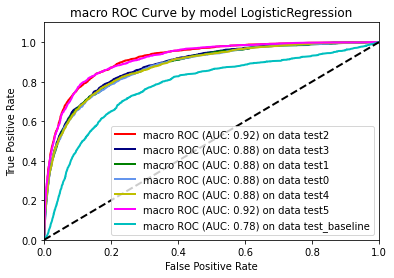

In [231]:
modelname="LogisticRegression"
data_type="both_embedding"
choose = "macro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

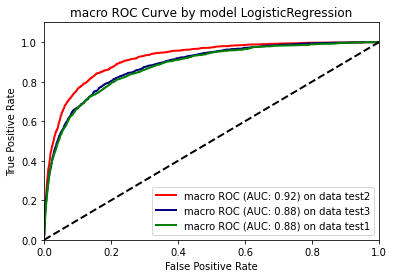

In [232]:
modelname="LogisticRegression"
data_type="word2vec"
choose = "macro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

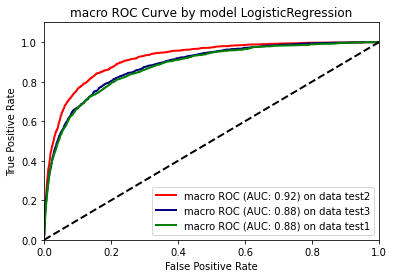

In [233]:
modelname="LogisticRegression"
data_type="glove"
choose = "macro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

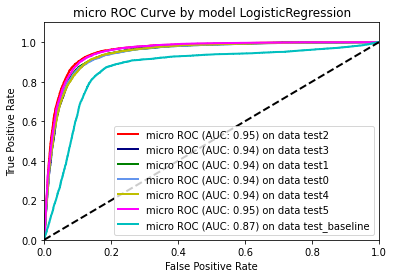

In [234]:
modelname="LogisticRegression"
data_type="both_embedding"
choose = "micro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

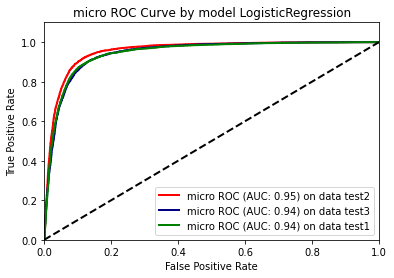

In [235]:
modelname="LogisticRegression"
data_type="word2vec"
choose = "micro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

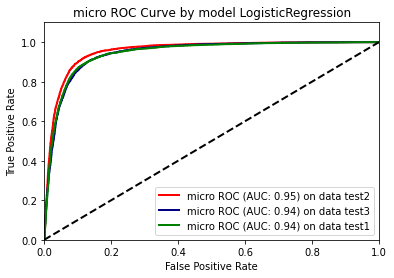

In [236]:
modelname="LogisticRegression"
data_type="glove"
choose = "micro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

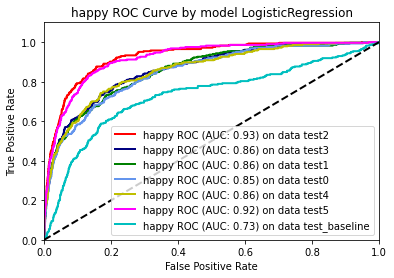

In [237]:
modelname="LogisticRegression"
data_type="both_embedding"
choose = "happy"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

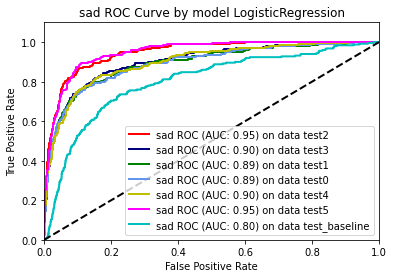

In [238]:
modelname="LogisticRegression"
data_type="both_embedding"
choose = "sad"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

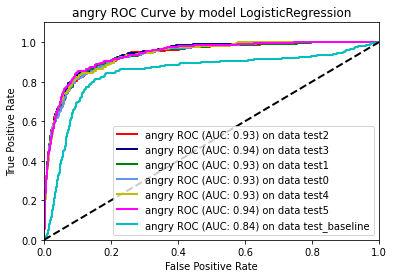

In [239]:
modelname="LogisticRegression"
data_type="both_embedding"
choose = "angry"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

## 3.2. SVM

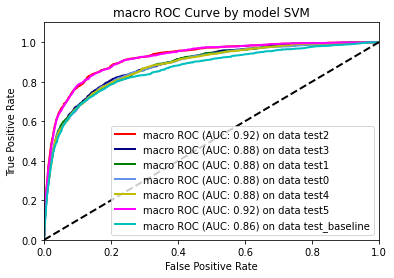

In [240]:
modelname="SVM"
data_type="both_embedding"
choose = "macro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

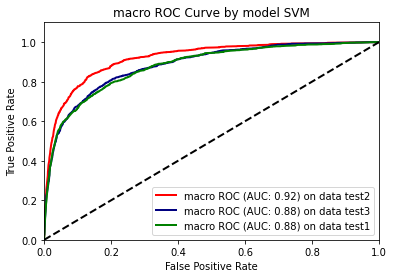

In [241]:
modelname="SVM"
data_type="word2vec"
choose = "macro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

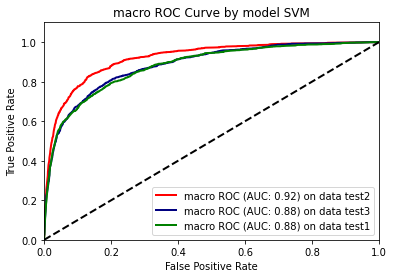

In [242]:
modelname="SVM"
data_type="glove"
choose = "macro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

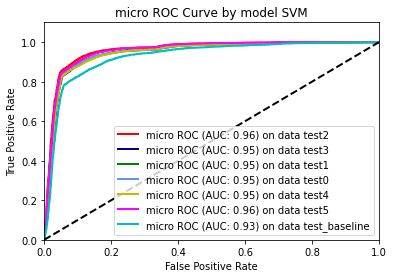

In [243]:
modelname="SVM"
data_type="both_embedding"
choose = "micro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

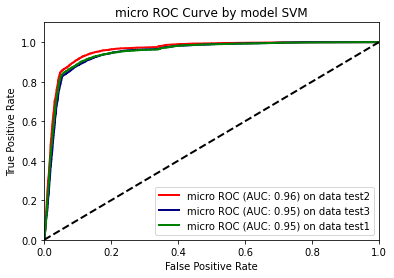

In [244]:
modelname="SVM"
data_type="word2vec"
choose = "micro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

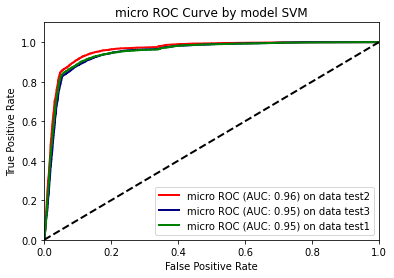

In [245]:
modelname="SVM"
data_type="glove"
choose = "micro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

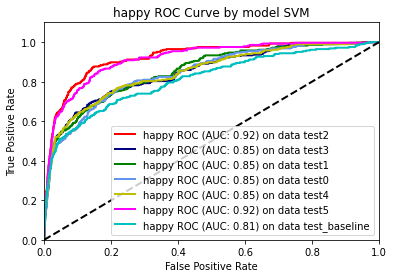

In [246]:
modelname="SVM"
data_type="both_embedding"
choose = "happy"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

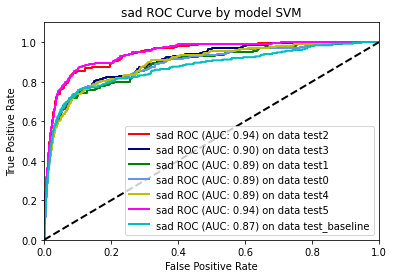

In [247]:
modelname="SVM"
data_type="both_embedding"
choose = "sad"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

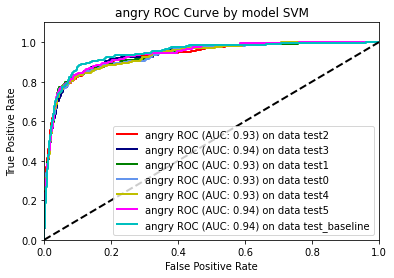

In [248]:
modelname="SVM"
data_type="both_embedding"
choose = "angry"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

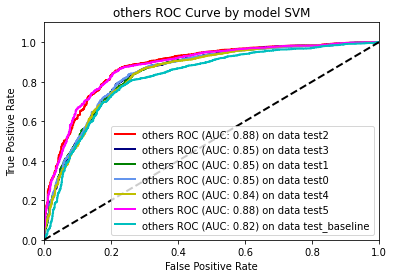

In [249]:
modelname="SVM"
data_type="both_embedding"
choose = "others"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

## 3.2.Kernel SVM

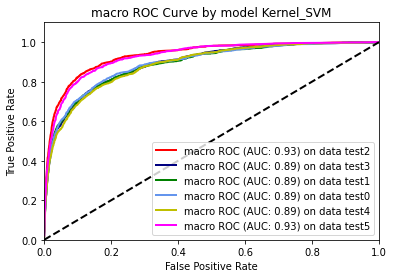

In [250]:
modelname="Kernel_SVM"
data_type="both_embedding"
choose = "macro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

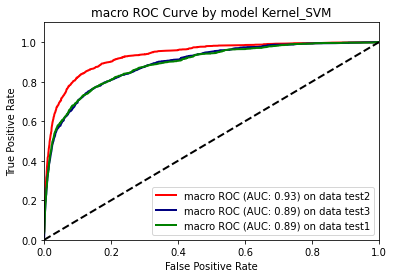

In [251]:
modelname="Kernel_SVM"
data_type="word2vec"
choose = "macro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

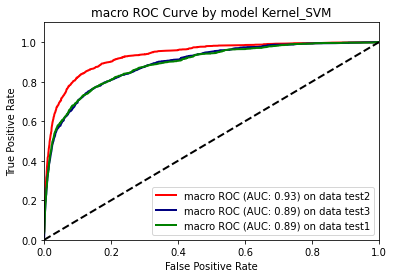

In [252]:
modelname="Kernel_SVM"
data_type="glove"
choose = "macro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

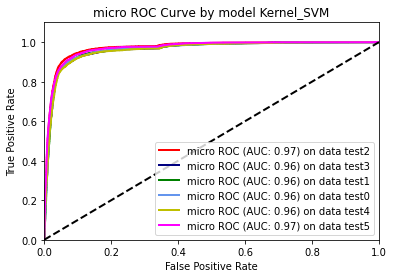

In [253]:
modelname="Kernel_SVM"
data_type="both_embedding"
choose = "micro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

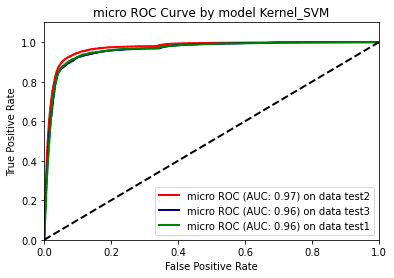

In [254]:
modelname="Kernel_SVM"
data_type="word2vec"
choose = "micro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

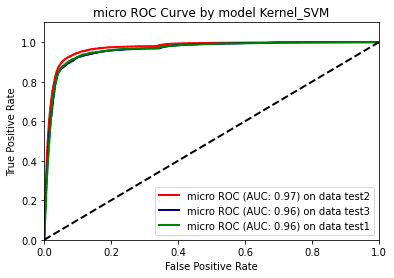

In [255]:
modelname="Kernel_SVM"
data_type="glove"
choose = "micro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

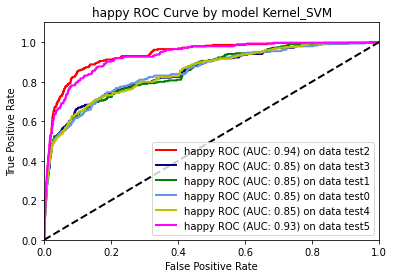

In [256]:
modelname="Kernel_SVM"
data_type="both_embedding"
choose = "happy"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

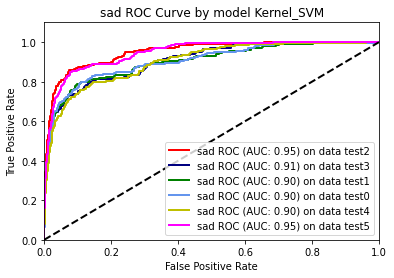

In [257]:
modelname="Kernel_SVM"
data_type="both_embedding"
choose = "sad"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

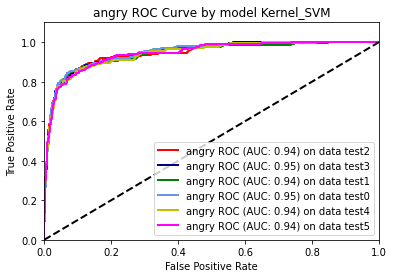

In [258]:
modelname="Kernel_SVM"
data_type="both_embedding"
choose = "angry"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

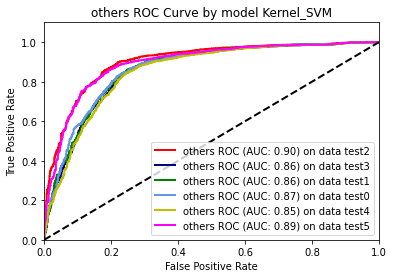

In [259]:
modelname="Kernel_SVM"
data_type="both_embedding"
choose = "others"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

## 3.3.CNN

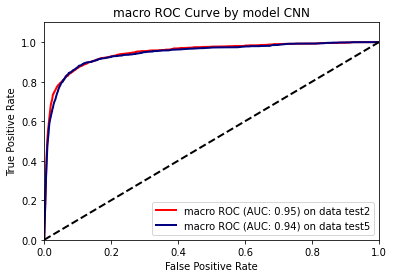

In [260]:
modelname="CNN"
data_type="both_embedding"
choose = "macro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

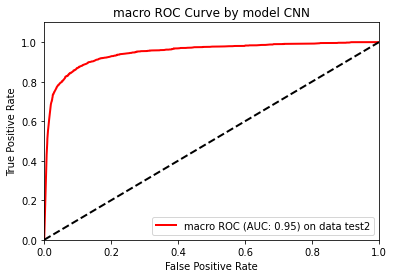

In [261]:
modelname="CNN"
data_type="word2vec"
choose = "macro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

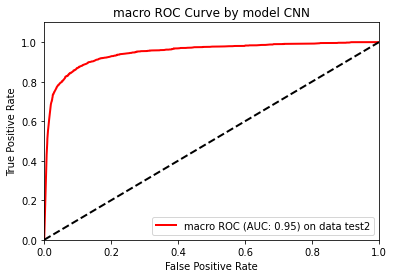

In [262]:
modelname="CNN"
data_type="glove"
choose = "macro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

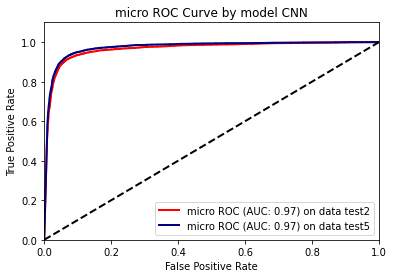

In [263]:
modelname="CNN"
data_type="both_embedding"
choose = "micro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

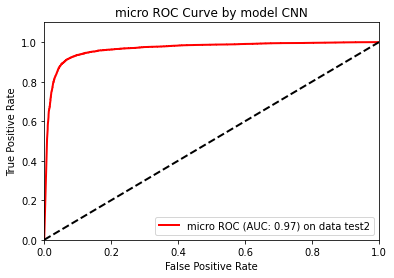

In [264]:
modelname="CNN"
data_type="word2vec"
choose = "micro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

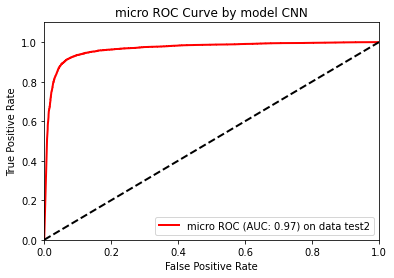

In [265]:
modelname="CNN"
data_type="glove"
choose = "micro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

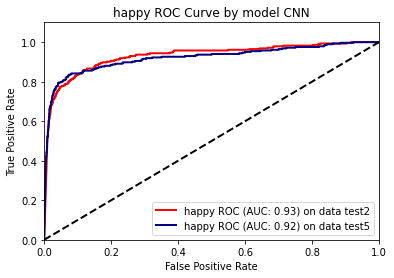

In [266]:
modelname="CNN"
data_type="both_embedding"
choose = "happy"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

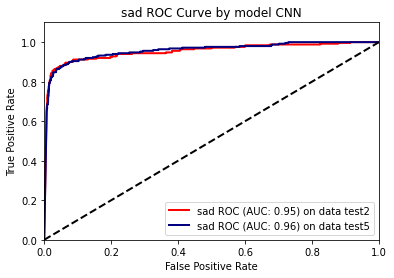

In [267]:
modelname="CNN"
data_type="both_embedding"
choose = "sad"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

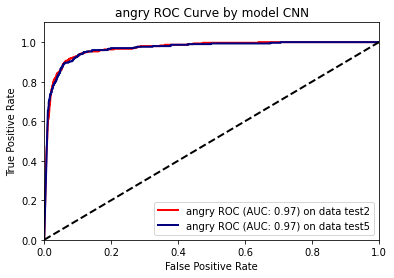

In [268]:
modelname="CNN"
data_type="both_embedding"
choose = "angry"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

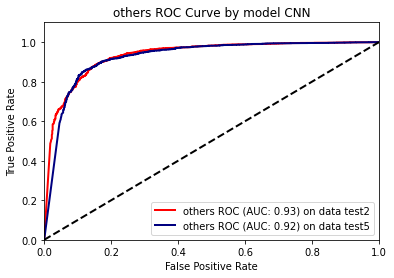

In [269]:
modelname="CNN"
data_type="both_embedding"
choose = "others"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

## 3.4.LSTM

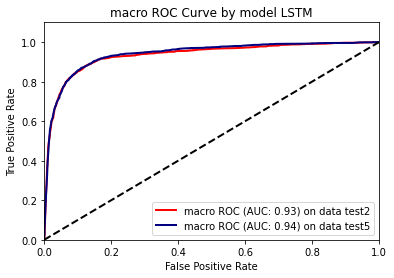

In [270]:
modelname="LSTM"
data_type="both_embedding"
choose = "macro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

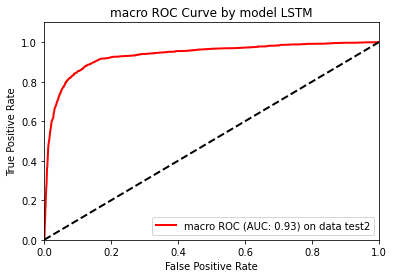

In [271]:
modelname="LSTM"
data_type="word2vec"
choose = "macro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

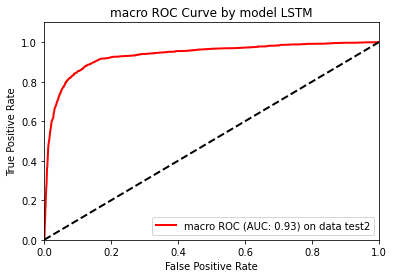

In [272]:
modelname="LSTM"
data_type="glove"
choose = "macro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

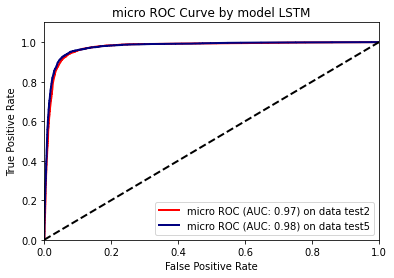

In [273]:
modelname="LSTM"
data_type="both_embedding"
choose = "micro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

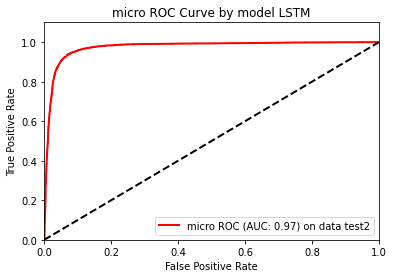

In [274]:
modelname="LSTM"
data_type="word2vec"
choose = "micro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

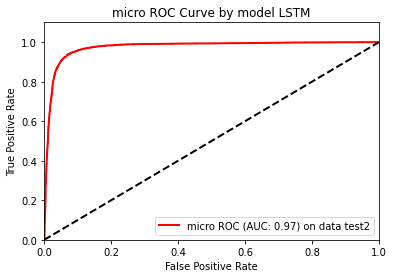

In [275]:
modelname="LSTM"
data_type="glove"
choose = "micro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

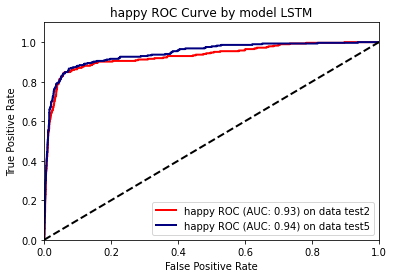

In [276]:
modelname="LSTM"
data_type="both_embedding"
choose = "happy"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

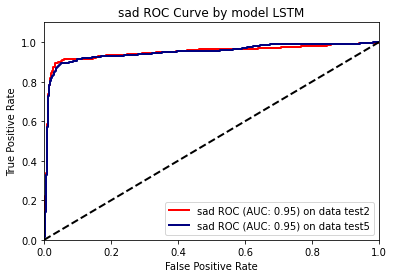

In [277]:
modelname="LSTM"
data_type="both_embedding"
choose = "sad"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

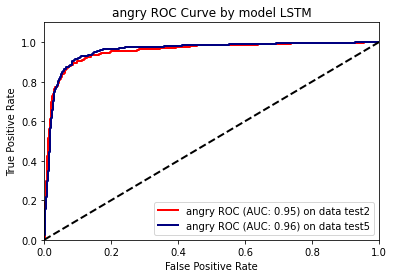

In [278]:
modelname="LSTM"
data_type="both_embedding"
choose = "angry"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

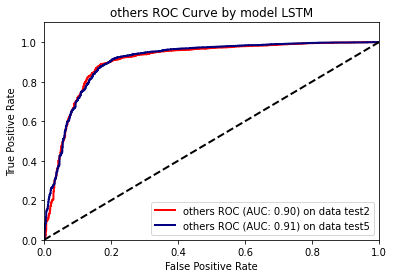

In [279]:
modelname="LSTM"
data_type="both_embedding"
choose = "others"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

## 3.5.GRU

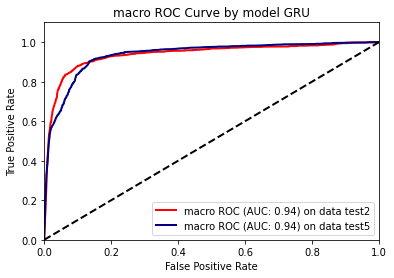

In [280]:
modelname="GRU"
data_type="both_embedding"
choose = "macro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

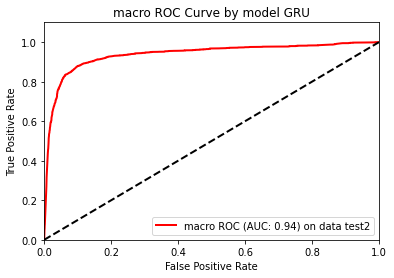

In [281]:
modelname="GRU"
data_type="word2vec"
choose = "macro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

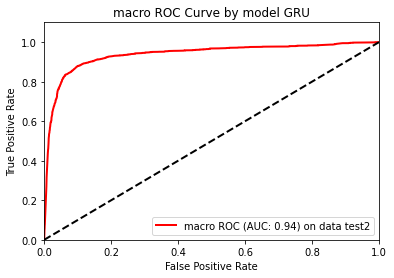

In [282]:
modelname="GRU"
data_type="glove"
choose = "macro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

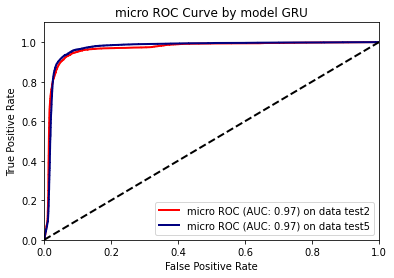

In [283]:
modelname="GRU"
data_type="both_embedding"
choose = "micro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

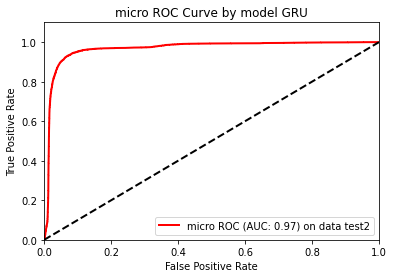

In [284]:
modelname="GRU"
data_type="word2vec"
choose = "micro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

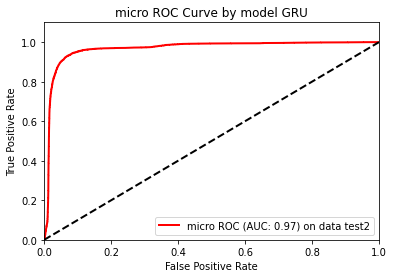

In [285]:
modelname="GRU"
data_type="glove"
choose = "micro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

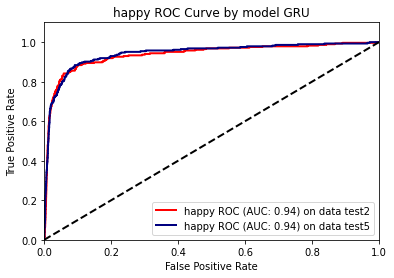

In [286]:
modelname="GRU"
data_type="both_embedding"
choose = "happy"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

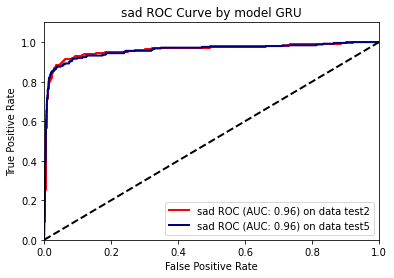

In [287]:
modelname="GRU"
data_type="both_embedding"
choose = "sad"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

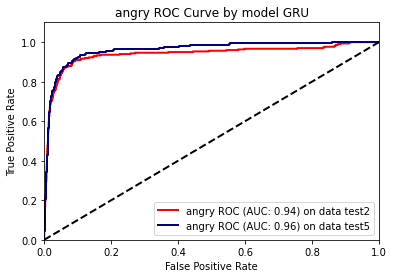

In [288]:
modelname="GRU"
data_type="both_embedding"
choose = "angry"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

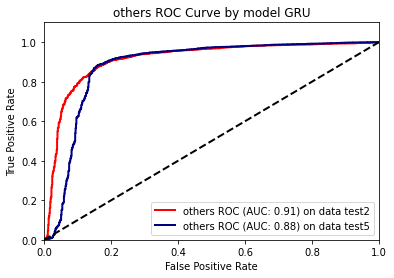

In [289]:
modelname="GRU"
data_type="both_embedding"
choose = "others"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

## 3.6.BiLSTM

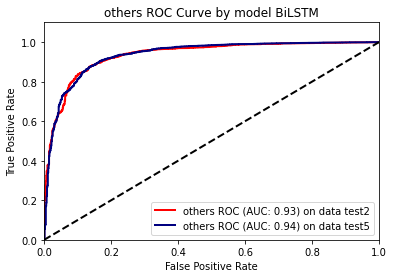

In [290]:
modelname="BiLSTM"
data_type="both_embedding"
choose = "others"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

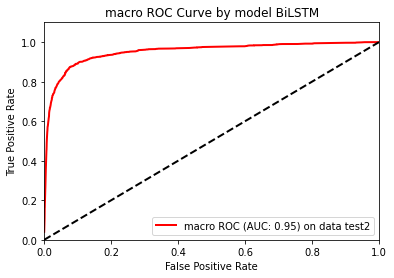

In [291]:
data_type="word2vec"
choose = "macro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

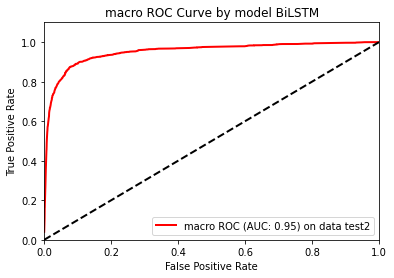

In [292]:
data_type="glove"
choose = "macro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

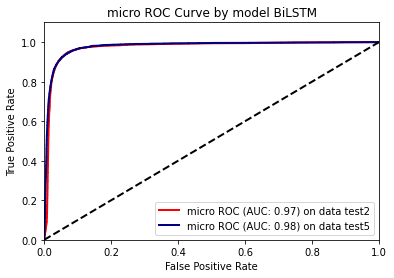

In [293]:
data_type="both_embedding"
choose = "micro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

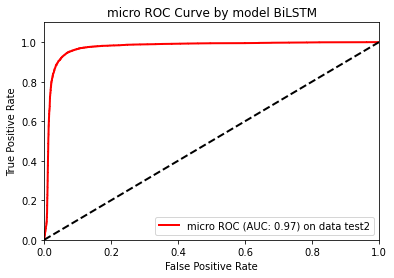

In [294]:
data_type="word2vec"
choose = "micro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

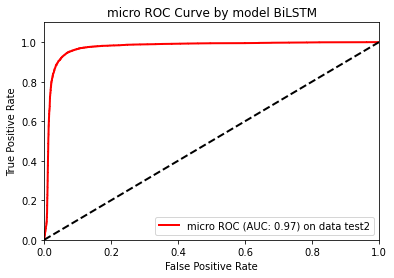

In [295]:
data_type="glove"
choose = "micro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

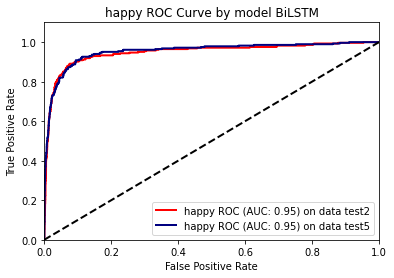

In [296]:
data_type="both_embedding"
choose = "happy"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

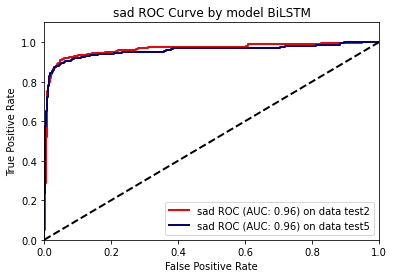

In [297]:
data_type="both_embedding"
choose = "sad"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

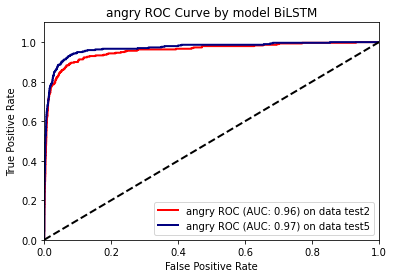

In [298]:
data_type="both_embedding"
choose = "angry"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

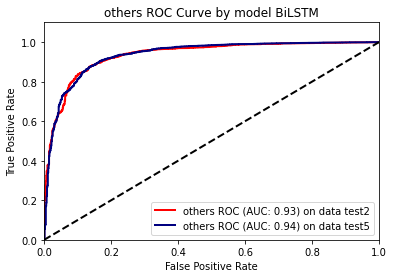

In [299]:
data_type="both_embedding"
choose = "others"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

## 3.7.BiGRU 

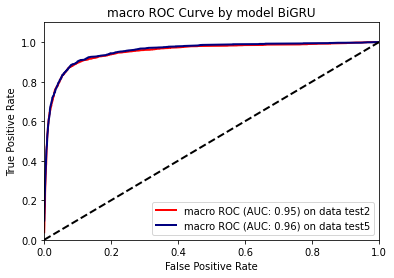

In [300]:
modelname="BiGRU"
data_type="both_embedding"
choose = "macro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

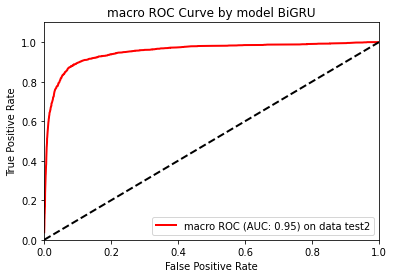

In [301]:
data_type="word2vec"
choose = "macro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

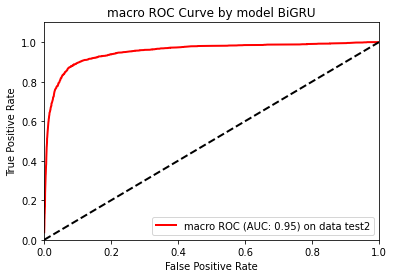

In [302]:
data_type="glove"
choose = "macro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

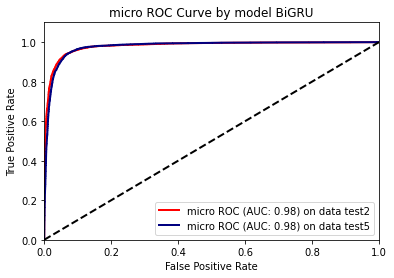

In [303]:
data_type="both_embedding"
choose = "micro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

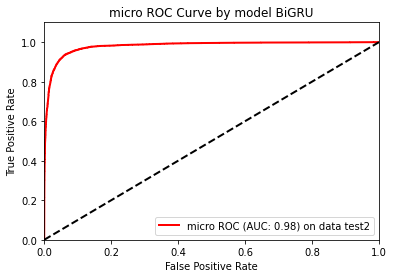

In [304]:
data_type="word2vec"
choose = "micro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

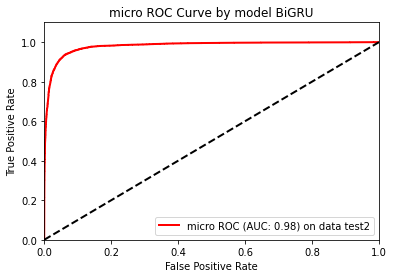

In [305]:
data_type="glove"
choose = "micro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

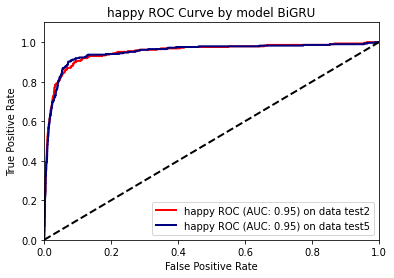

In [306]:
data_type="both_embedding"
choose = "happy"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

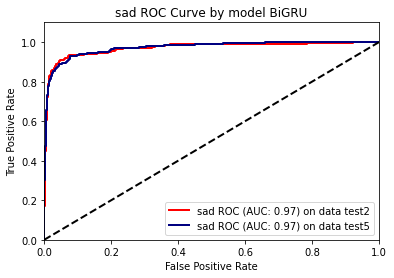

In [307]:
data_type="both_embedding"
choose = "sad"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

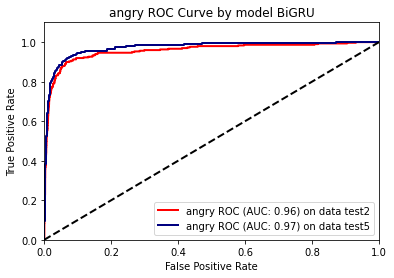

In [308]:
data_type="both_embedding"
choose = "angry"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

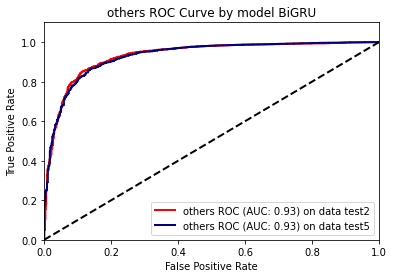

In [309]:
data_type="both_embedding"
choose = "others"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

## 3.8.BiLSTM_self_attention

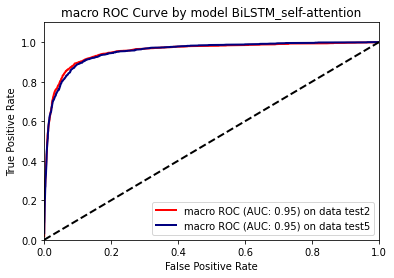

In [310]:
modelname="BiLSTM_self-attention"
data_type="both_embedding"
choose = "macro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

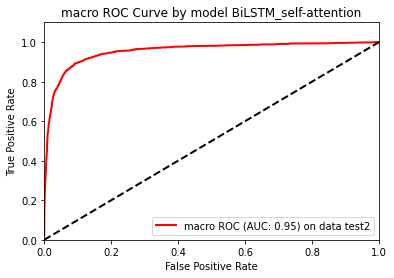

In [311]:
data_type="word2vec"
choose = "macro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

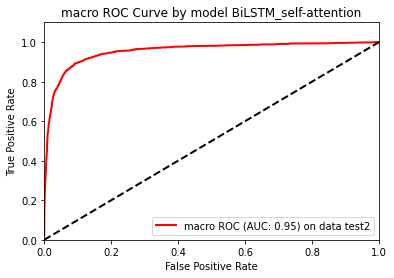

In [312]:
data_type="glove"
choose = "macro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

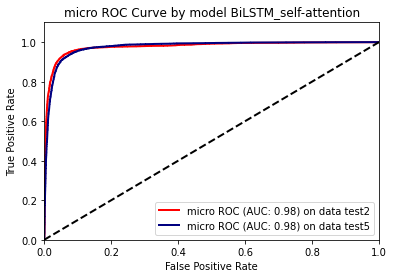

In [313]:
data_type="both_embedding"
choose = "micro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

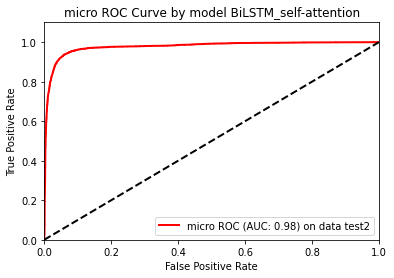

In [314]:
data_type="word2vec"
choose = "micro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

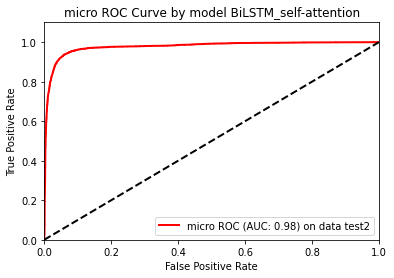

In [315]:
data_type="glove"
choose = "micro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

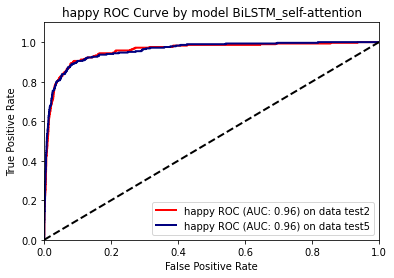

In [316]:
data_type="both_embedding"
choose = "happy"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

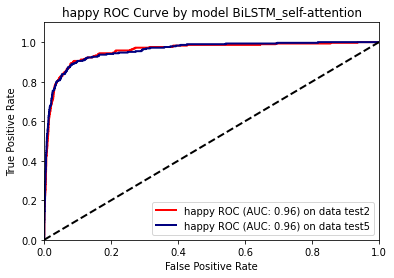

In [317]:
data_type="both_embedding"
choose = "happy"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

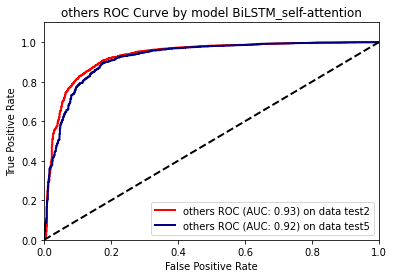

In [318]:
data_type="both_embedding"
choose = "others"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

## 3.9. BiGRU_self_attention

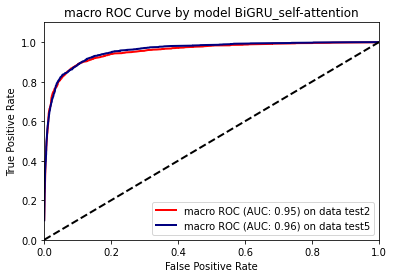

In [319]:
modelname="BiGRU_self-attention"
data_type="both_embedding"
choose = "macro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

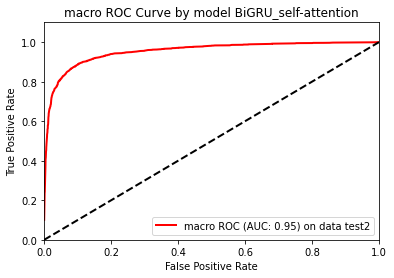

In [320]:
data_type="word2vec"
choose = "macro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

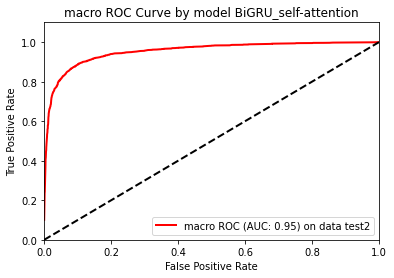

In [321]:
data_type="glove"
choose = "macro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

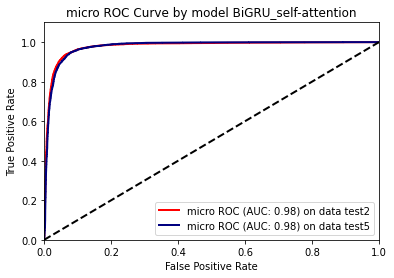

In [322]:
data_type="both_embedding"
choose = "micro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

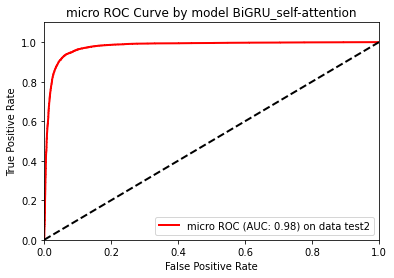

In [323]:
data_type="word2vec"
choose = "micro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

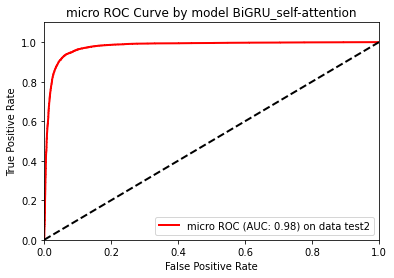

In [324]:
data_type="glove"
choose = "micro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

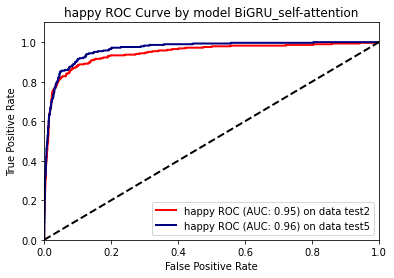

In [325]:
data_type="both_embedding"
choose = "happy"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

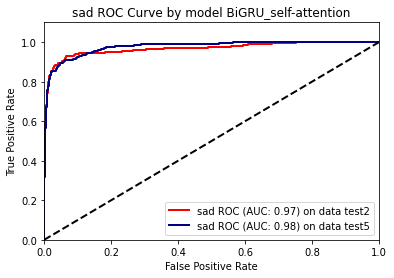

In [326]:
data_type="both_embedding"
choose = "sad"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

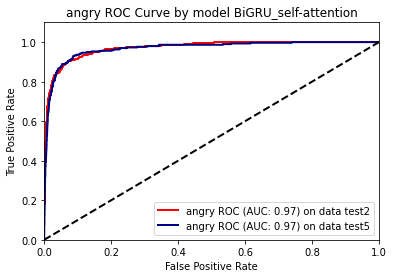

In [327]:
data_type="both_embedding"
choose = "angry"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

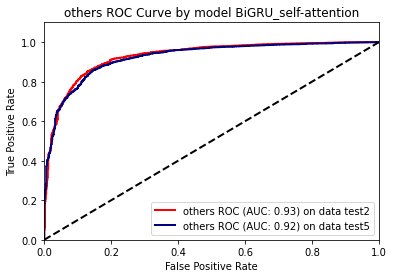

In [328]:
data_type="both_embedding"
choose = "others"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

# 4.Evaluation with ROC, AUC on different model

In [329]:
def draw_pic_diff(fpr_range,tpr_range,roc_auc,modelname,choose,color):
    emotion_no={
            0:"others",
            1:"happy",
            2:"sad",
            3:"angry"
     }
    if choose != "micro" and choose !="macro":
        label_name = emotion_no[choose]
    else:
        label_name = choose
    
    plt.plot(fpr_range[choose],tpr_range[choose],color=color,lw=2,
             label="{0} ROC (AUC: {1:0.2f}) by {2}".format(label_name,roc_auc[choose],modelname))

In [332]:
def draw_comparison_diff(all_fprs,all_tprs,all_roc_aucs,data_version,choose="micro"):
    modelnames=list(all_fprs.keys())
    

    emotion = {"others":0,"happy":1,"sad":2,"angry":3}
    
    # set colors choice
    colors = ["r","navy", "g","cornflowerblue","y","magenta","c","pink","olivedrab","coral","darkgreen","maroon","olivedrad","thistle"]
    
    label_name = choose
    
    # set the label_name, i.e. choose to its number type if it's happy, sad, angry, others.
    if choose !="micro" and choose !="macro":
        choose = emotion[choose]
    
    
    plt.figure()
    
    # draw the line based on data resource type
    for pos in range(len(modelnames)):
        try:
            each_model = modelnames[pos]
            color = colors[pos]
            modelname = re.sub(r'\_scores','',each_model)
            draw_pic_diff(all_fprs[each_model][data_version],all_tprs[each_model][data_version],
                 all_roc_aucs[each_model][data_version],modelname,choose,color)
        except KeyError:
            continue
    
    
    
    plt.plot([0,1],[0,1],linestyle="--",color='k',lw=2)
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('{a} ROC Curve with all models on data {b}.png'.format(a=label_name,b=data_version))
    
    plt.legend(loc="lower right")
    plt.savefig("Pictures\\{a} ROC Curve with all models on data {b}.png".format(a=label_name,b=data_version))
    plt.show()
    

## 4.1. test2
- data based on word2vec
- data with correction of misspell and translation of shorthand words and acronyms
- data with emoji/emoticon values inside

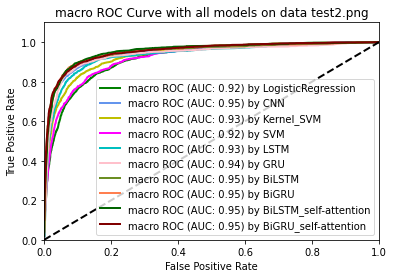

In [334]:
data_version="test2"
choose = "macro"
draw_comparison_diff(all_fprs,all_tprs,all_roc_aucs,data_version,choose)

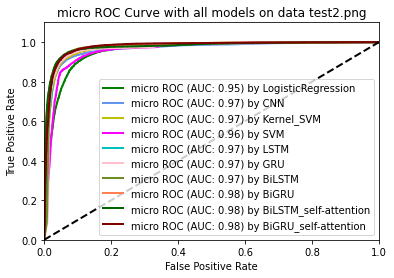

In [335]:
data_version="test2"
choose = "micro"
draw_comparison_diff(all_fprs,all_tprs,all_roc_aucs,data_version,choose)

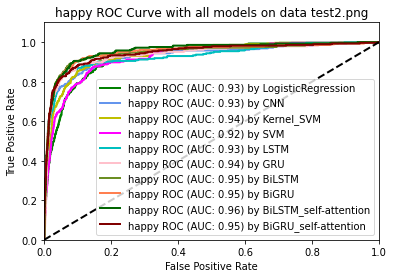

In [336]:
data_version="test2"
choose = "happy"
draw_comparison_diff(all_fprs,all_tprs,all_roc_aucs,data_version,choose)

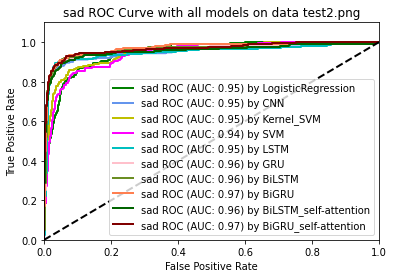

In [337]:
data_version="test2"
choose = "sad"
draw_comparison_diff(all_fprs,all_tprs,all_roc_aucs,data_version,choose)

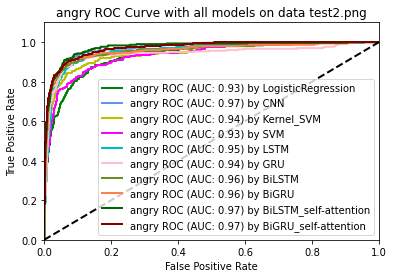

In [338]:
data_version="test2"
choose = "angry"
draw_comparison_diff(all_fprs,all_tprs,all_roc_aucs,data_version,choose)

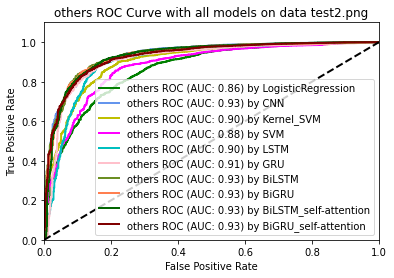

In [339]:
data_version="test2"
choose = "others"
draw_comparison_diff(all_fprs,all_tprs,all_roc_aucs,data_version,choose)

## 4.2. test5
- data based on glove
- data with correction of misspell and translation of shorthand words and acronyms
- data with emoji/emoticon values inside

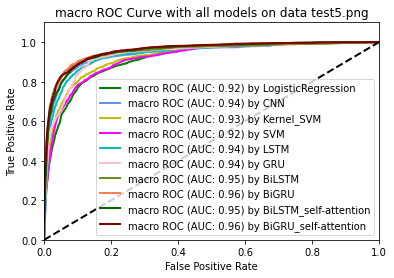

In [340]:
data_version="test5"
choose = "macro"
draw_comparison_diff(all_fprs,all_tprs,all_roc_aucs,data_version,choose)

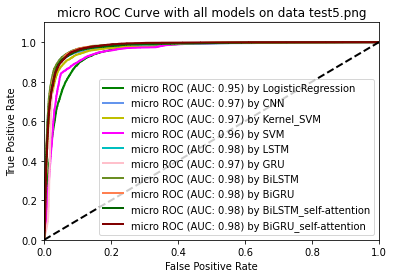

In [341]:
data_version="test5"
choose = "micro"
draw_comparison_diff(all_fprs,all_tprs,all_roc_aucs,data_version,choose)

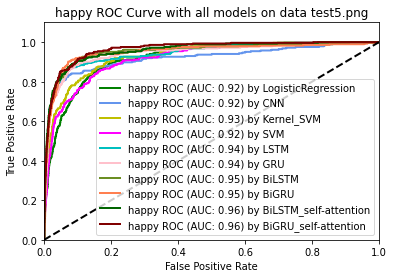

In [342]:
data_version="test5"
choose = "happy"
draw_comparison_diff(all_fprs,all_tprs,all_roc_aucs,data_version,choose)

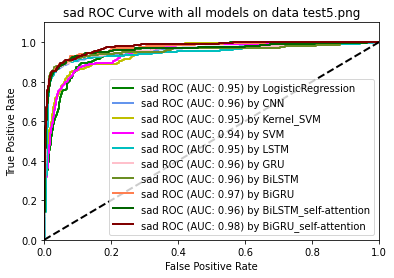

In [343]:
data_version="test5"
choose = "sad"
draw_comparison_diff(all_fprs,all_tprs,all_roc_aucs,data_version,choose)

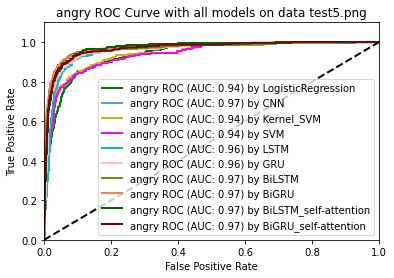

In [344]:
data_version="test5"
choose = "angry"
draw_comparison_diff(all_fprs,all_tprs,all_roc_aucs,data_version,choose)

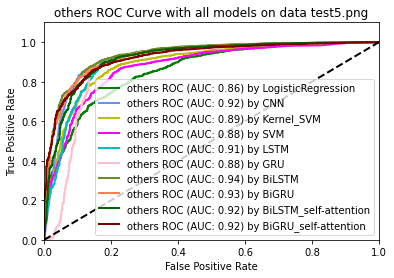

In [345]:
data_version="test5"
choose = "others"
draw_comparison_diff(all_fprs,all_tprs,all_roc_aucs,data_version,choose)